# Equation de Poisson

Au cours de ce TP, on cherche à résoudre l'équation de Poisson :

$$ \frac{\partial^2}{\partial x^2}u(x,y)+\frac{\partial^2}{\partial y^2}u(x,y)=f(x,y) $$
 
avec $f$ une fonction source.

Pour cela, on résoud par la méthode des différences finies, en définissant un maillage de l'espace. On limite ce maillage à une portion du plan $xy$. On limite le plan entre $0$ et $I$ selon $x$ et entre $0$ et $J$ selon $y$. 
$$
\left\{
    \begin{array}{ll}
        x_{i}=x_{0}+i\Delta x \quad 0 \leq x < I
        \\
        y_{i}=y_{0}+j\Delta x \quad 0 \leq x < J
    \end{array}
\right.
$$

Dans notre cas, nous allons nous intérésser à une fonction de Poisson en particulier : celle d'un potentiel électrostatique en présence de charge.

$$  \frac{\partial^2 V}{\partial x^2}+\frac{\partial^2 V}{\partial y^2}=\frac{\rho (x,y)}{\epsilon_{0}} $$

$\rho$ = densité volumique de charges

$\epsilon_{0}$ = permitivité relative du vide 

On choisit $I=J=1$ et on fait un maillage à 65 points.

In [1]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import scipy.sparse as sp                 
from scipy.sparse.linalg import spsolve
import scipy.sparse as sp

   

### Conditions aux limites de Dirichlet et Maillage de l'espace

In [2]:
# Conditions de Dirichlet sur les bords du maillage
uL = 0
uR = 0
uT = 0
uB = 0

#Conditions de Dirichlet dans l'espace
eo = 8.85e-12
upos = 1/eo
uneg = -1/eo

# Maillage de l'espace
I = 65
J = 65                       
x = np.linspace(0,1,I)     
y = np.linspace(0,1,J)        

dx = x[1] - x[0]                #pas selon x
dy = y[1] - y[0]                #pas selon y

X,Y = np.meshgrid(x,y)       #création de la matrice de maillage   

# Réindexation 2D à 1D
Xu = X.ravel()                  # Créer l'array des abscisses 1D
Yu = Y.ravel()

#Création du condensateur
 
xlimite = [0.25, 0.75]        # on limite la zone de x 
k = np.floor(0.4/dy)          #ce sont les lignes qui correspondent aux lignes dans le maillage ou on a y  = 0.4 et y = 0.6
k1 = np.floor(0.6/dy)
yupos = k*dy                 # j'ai ajusté avec la partie entière pour qu'on ai approximativement 0.4 (c'est dû au maillage que je réalise avec la fonciton linspace)
yuneg = k1*dy                 #pareil pour que ça donne 0.6 approximativement mais pour que ça tombe juste sur le maillage

print(k,k1)


25.0 38.0


Ici, on choisit d'imposer les conditions de Dirichlet pour fixer les conditions au bord. On aurait pu imposer les conditions de Neumann mais comme le choix de l'exemple était avec les conditions de Dirichlet, nous avons choisi de continuer avec celle-ci. De plus, les conditions de Neumann sont plus imposés lorsque l'on a des situations avec des conditions de bords dites "infinis" ce qui n'est pas le cas dans l'exemple ici

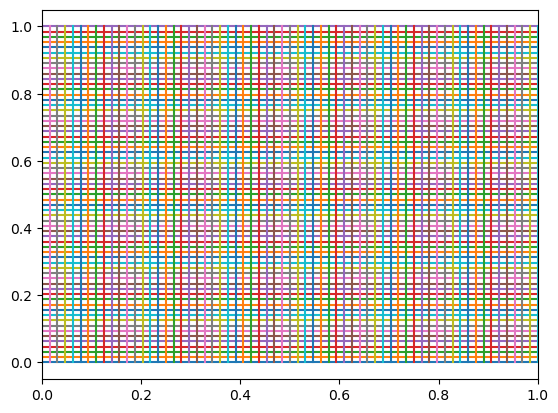

In [3]:
#Création du maillage sur x et y 
plt.plot(X)
plt.plot(X,Y)
plt.xlim([0,1])
plt.show()

In [4]:
# Indices des bords pour construire la boite avec les conditions de Dirichlet

ind_bord_gauche = np.squeeze(np.where(Xu==x[0]))          # renvoie l'indice des bords à gauche de la boite 
ind_bord_droit = np.squeeze(np.where(Xu==x[I-1]))       
ind_bord_bas = np.squeeze(np.where(Yu==y[0]))         
ind_bord_haut = np.squeeze(np.where(Yu==y[J-1]))  

# Indices des lignes de charges positives et négatives
#ligne positive
list_charge_pos = np.squeeze(np.where((Xu>xlimite[0]) & (Xu<xlimite[1]) & (Yu==yupos)))  # renvoie l'indice des lignes ou il y a les charges positives dans la liste déroulée de la matrice
list_charge_pos_reel = np.where((X>xlimite[0]) & (X<xlimite[1]) & (Y==yupos))    # renvoie la position des lignes ou il y a les charges positives sur la vrai matrice de maillage
#ligne négative
list_charge_neg = np.squeeze(np.where((Xu>xlimite[0]) & (Xu<xlimite[1]) & (Yu==yuneg)))  # renvoie l'indice des lignes ou il y a les charges négatives
list_charge_neg_reel = np.where((X>xlimite[0]) & (X<xlimite[1]) & (Y==yuneg))    

# Indices du maillages
ind_bords_unravel = np.squeeze(np.where((Xu==x[0]) | (Xu==x[I-1]) | (Yu==y[0]) | (Yu==y[J-1])))  # tous les bords en indice listé 
ind_bords = np.where((X==x[0]) | (X==x[I-1]) | (Y==y[0]) | (Y==y[J-1]))    # tous les bords/leur position réel sur le maillage

print(ind_bord_bas, ind_bord_gauche, list_charge_neg_reel)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64] [   0   65  130  195  260  325  390  455  520  585  650  715  780  845
  910  975 1040 1105 1170 1235 1300 1365 1430 1495 1560 1625 1690 1755
 1820 1885 1950 2015 2080 2145 2210 2275 2340 2405 2470 2535 2600 2665
 2730 2795 2860 2925 2990 3055 3120 3185 3250 3315 3380 3445 3510 3575
 3640 3705 3770 3835 3900 3965 4030 4095 4160] (array([38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
      dtype=int64), array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
      dtype=int64))


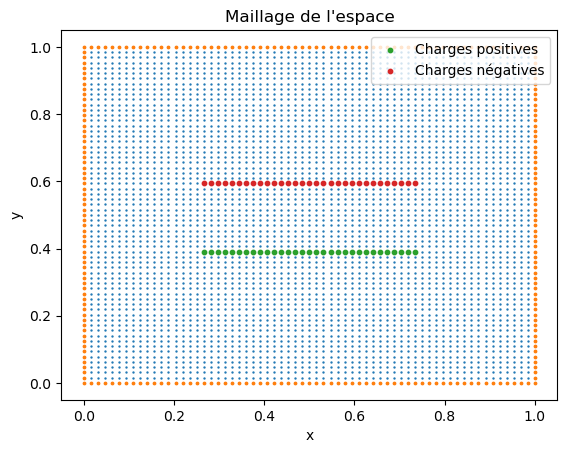

In [5]:
plt.scatter(X,Y,2,marker = '.') # création de l'espace maillé
plt.scatter(X[ind_bords],Y[ind_bords],3) # création des bords
plt.scatter(X[list_charge_pos_reel],Y[list_charge_pos_reel],10, label = 'Charges positives')
plt.scatter(X[list_charge_neg_reel],Y[list_charge_neg_reel],10,label = 'Charges négatives')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Maillage de l'espace")
plt.legend()

### Lignes de charge

La densité volumique de charges dépend des coordonées. On a :

- Une ligne de charge positive pour $y=0.4$ et $0.25 \leq x \leq 0.75$
- Une ligne de charge négative pour $y=0.6$ et $0.25 \leq x \leq 0.75$

Ici, on voit qu'on a bien réalisé le maillage de l'espace, et qu'on a bien placé les charges positives et négatives et qu'on a fixé les conditions de Dirichlet sur les bords. La première phase d'initialisation est finie !

In [6]:
# Construction du vecteur source du système de Poisson

#Création de la matrice source 

b = np.zeros(I*J) 
b[ind_bord_gauche] = uL # on rajoute les conditions sur les bords du maillage, ici à gauche
b[ind_bord_droit] = uR
b[ind_bord_haut] = uT
b[ind_bord_bas] = uB

b[list_charge_pos] = upos # on rajoute les charges positives et négatives sur les lignes dans le vecteur b
b[list_charge_neg] = uneg # on prendra en compte par la suite du -rho de l'équation de Poisson 

print(b)

[0. 0. 0. ... 0. 0. 0.]


## Implémentation des méthodes de résolution de l'équation

#### Pivot de Gauss

In [7]:
# Implémentation du pivot de Gauss pour résoudre un systeme du type Ax = B, même si je n'y crois pas trop pour N = 65

def produit(A, B):
    return [[sum(L[k] * B[k][j] for k in range(len(L))) for j in range(len(B[0]))] for L in A]

def echange_lignes(M, i, j):
   M[i], M[j] = M[j], M[i]
   return M
   
def transvection_ligne(M, i, j, l):
    M[i] = [M[i][k] + l * M[j][k] for k in range(len(M[i]))]
    return M
   
def dilatation_ligne(M, i, l):
    M[i] = [coeff * l for coeff in M[i]]
    return M
   
def recherche_pivot_lignes(M, i):
    m = abs(M[i][i])
    j = i
    for k in range(i + 1, len(M)):
        if abs(M[i][j]) > m:
            j = k
    return j
   
def pivot_lignes(M):
   for i in range(len(M)):
        j = recherche_pivot_lignes(M, i)
        if j != i:
            echange_lignes(M, i, j)
        if M[i][i] != 0:
            for j in range(i + 1, len(M)):
                transvection_ligne(M, j, i, -M[j][i] / M[i][i])
   return M
   
def concatenation_vecteur(A, B):
    return [A[i] + [B[i]] for i in range(len(A))]

def pivot_lignes_rebours(M):
    for i in reversed(range(len(M))):
        dilatation_ligne(M, i, 1 / M[i][i])
        for j in range(i):
            transvection_ligne(M, j, i, -M[j][i])
    return M

def extract_vecteur(M):
    return [L[-1] for L in M]

def resolution(A, B):
    M = concatenation_vecteur(A, B)
    pivot_lignes(M)
    pivot_lignes_rebours(M)
    return extract_vecteur(M)

In [8]:
A = [[1, -1, 2], [3, 2, 1], [2, -3, -2]]
B = [5, 10, -10]
resolution(A,B)

[1.0, 2.0, 3.0]

#### Calcul des dérivées partielles de l'équation de Poisson pour la méthode Sparse/Sur-relaxation/Gauss

In [9]:
#Création de la matrice système par la méthode classique des éléments finis on créé une matrice de taille (I*I,J*J) pour qu'il fit avec le vecteur b source
def A_sys(n,dx):
    h = dx #le pas
    A = np.zeros((n*n, n*n), dtype=float) #Construction de la matrice système d'équations 
    for i in range(n*n):
        A[i, i] = -4 #ne marche que si le pas est le même dans le sens des x et y (a voir dans la formule de Taylor)
    for i in range(n):
        for j in range(n-1):
            A[n*i+j, n*i+j+1] = 1 #coefficient à voir avec la formule de Taylor du pdf
            A[n*i+j+1, n*i+j] = 1
    for i in range(n-1):
        for j in range(n):
            A[n*(i+1)+j, n*i+j] = 1
            A[n*i+j, n*(i+1)+j] = 1
    return(A)
    
# Méthode utilisant la méthode des différences finies
#avec np.linalg.solve pour résoudre le système 
def poisson_matrice_linalg(n, dx):
    A = A_sys(n,dx)
    v = -b # le vecteur source de l'équation de Poisson, on met un - devant b pour prendre en compte le -rho dans l'équation de Poisson 
    return np.linalg.solve(A, v).reshape((n, n))

#par la méthode du pivot de gauss
def poisson_matrice_gauss(n, dx):
    A = A_sys(n,dx)
    v = -b
    return resolution(A, v).reshape((n, n))

# Avec la méthode de sur relaxation, j'ai décidé d'implémenter directement la sur relaxation plutôt que de passer par Gauss Seidel
# Si j'ai bien compris les maths derrière, on utilise des suites pour résoudre des systèmes linéaires de types Ax=b en écrivant 
# A = D -E-F avec D une matrice diagonale, E une matrice triangulaire supérieur et F inférieur. On aboutit après calcul Ax = b à 
# la formule donnée par le pdf du github en injectant le paramètre w dans l'équation.
# Je passe directement à la méthode de Sur relaxation car la méthode de gauss seidel est la méthode de sur relaxation pour omega = 1
def poisson_relax(A, b, w, eps, max_iterations):
    x = np.zeros_like(b, dtype=np.double)
    for k in range(max_iterations):
        x_old  = x.copy() #il faut bien faire gaffe à garder les anciennes valeurs avant actualisation sinon on va faire un mauvais calcul
        for i in range(A.shape[0]):
            x[i] = x[i]*(1-w) + (w/A[i,i])*(b[i] - np.matmul(A[i,:i], x[:i]) - np.matmul(A[i,(i+1):], x_old[(i+1):])) #formule du pdf
        LnormInf = max(abs((x - x_old)))/max(abs(x_old)) 
        if  LnormInf < eps: #on utilise ici un critère de convergence relatif qui va nous servir comme condition d'arrêt de la boucle d'itération par rapport à une précision souhaitée
            break    # je n'ai pas utilisé de while car ça ne marchait pas avec mon ordi la boucle tournait quasi infiniment donc j'ai mis un nombre max d'itérations
    return x


# Calcul des dérivées partielles de l'équation de Poisson pour la méthode Sparse dans un premier temps on travaille sur une seule dimension et ensuite on l'étend en 2D au maillage 
# Ici comme on manipule des matrices pleines de 0, on utilise la méthode sparse qui consiste à remplir les matrices avec seulement les endroits ou l'élement est non nul attention
# si il y a pas beaucoup de zero cette méthode est très longue car on remplit un par un la matrice mais dans notre cas on manipule des matrices creuses donc on peut utiliser cette 
# méthode 

def Derive1D(Nx):
    # Première dérivée
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx)) # on doit diviser par le pas au carré mais je le ferai à la fin 
    D_1d = sp.lil_matrix(D_1d)                  # Ici on crée la matrice de diag nul, la diag supérieur a celle centrale qui vaut que des 1 et celle d'en dessous qui vaut que des -1 
    D_1d[0,[0,1,2]] = [1, -4, 1]               # on créer la première dérivée en accord avec la formule de Taylor
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 1]  
    # Seconde dérivée
    D2_1d =  sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx)) # on doit diviser par le pas au carré mais je le ferai à la fin
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [1, 1, -4, 1]                    
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [1, -4, 1, 1]  
    return D_1d, D2_1d


def Derive2D(Nx,Ny):
    Dx_1d, D2x_1d = Derive1D(Nx) #on récupère les premières dérivées 1D à la bonne dimension 
    Dy_1d, D2y_1d = Derive1D(Ny)
    # matrice identité sparse
    Ix = sp.eye(Nx)
    Iy = sp.eye(Ny)
    # utilisation du produit de kronecker avec l'identité sparse pour la fabriquation de la matrice du système comprenant les deux dérivées partielles
    # Première dérivée partielle
    Dx_2d = sp.kron(Iy,Dx_1d)
    Dy_2d = sp.kron(Dy_1d,Ix)
    # deuxième dérivée partielle
    D2x_2d = sp.kron(Iy,D2x_1d)
    D2y_2d = sp.kron(D2y_1d,Ix)
    return Dx_2d.tocsr(), Dy_2d.tocsr(), D2x_2d.tocsr(), D2y_2d.tocsr()  #format de la sparse matrice



## Résolution et comparaison des méthodes

In [18]:
# Résolution de l'équation avec la méthode du pivot de Gauss

start2 = time.time()
u2 = poisson_matrice_gauss(I,dx)
end2 = time.time()
temps_gauss = end2-start2
plt.figure(3)
plt.contourf(x,y,u1,41,cmap ='cosmos')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode du pivot de Gauss")

print('Le temps pour la méthode linalg.solve est',temps_gauss)

#Ici on se rends compte que le temps de calcul est beaucoup trop long... J'aurai essayé au moins mais la méthode du pivot de Gauss est ici 
#impossible à appliquer personellement je n'ai pas assez de memoire de ram pour lancer le programme

KeyboardInterrupt: 

Text(0.5, 1.0, "Résolution de l'équation de Poisson avec la méthode Sparse de scipy")

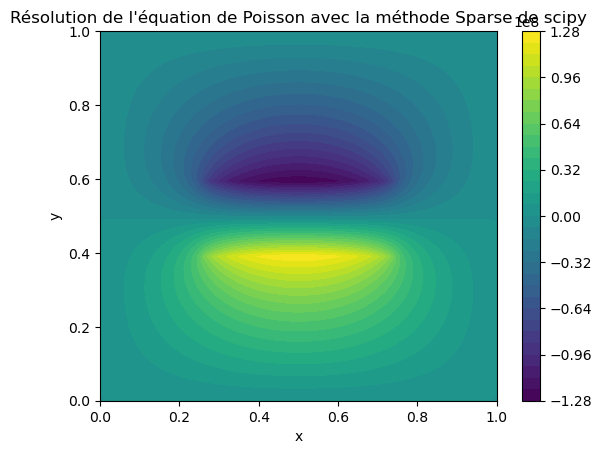

In [10]:
# Résolution de l'équation de Poisson avec la méthode sparse

start1 = time.time()
Dx_2d, Dy_2d, D2x_2d, D2y_2d = Derive2D(I,J)  #on initialise les dérivées 2D secondes dans l'équation de Poisson
I_sp = sp.eye(I*J).tocsr()
L_sys = D2x_2d/dx**2 + D2y_2d/dy**2     # on construit le système sans les conditions au limite avec les fonctions dérivées précédemment écrites
L_sys[ind_bords_unravel,:] = I_sp[ind_bords_unravel,:] #on rajoute les conditions au limite
u = spsolve(L_sys,-b).reshape(I,J) #on met -b car pour prendre en compte le -devant le rho dans l'équation de poisson et avoir les charges négatives en haut
end1 = time.time()
temps_sparse = end1-start1
plt.figure(1)
plt.contourf(x,y,u,41) #à chaque point de l'espace, on y associe une valeur du potentiel
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode Sparse de scipy")


On retrouve bel et bien ici la figure de potentiel d'un condensateur tel qu'on le connait. On a bien un potentiel négatif pour les charges négative en haut en y= 0.6 et un potentiel positif pour les charges positives en y = 0.4. On remarque également que le potentiel à l'intérieur des deux plaques n'est pas uniforme sur les bords, mais peut l'être considéré au centre. De plus, on retrouve les potentiels en sin(theta) à l'extérieur du condensateur pour chaque plaque, que l'on peut retrouver avce le champ E d'un condensateur. On a des résultats graphiques cohérents c'est encourageant !

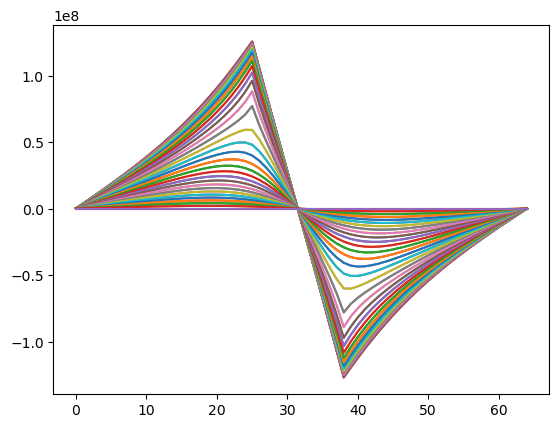

In [11]:
plt.plot(u)

Nous avons bien le max de potentiel positif (des charges positives) pour chaque fonction en 25 qui correspond à la ligne 25 où sont plaçés les charges positives (resp. négatives pour la ligne 38)

Text(0.5, 1.0, "Résolution de l'équation de Poisson avec la méthode linalg.solve de numpy")

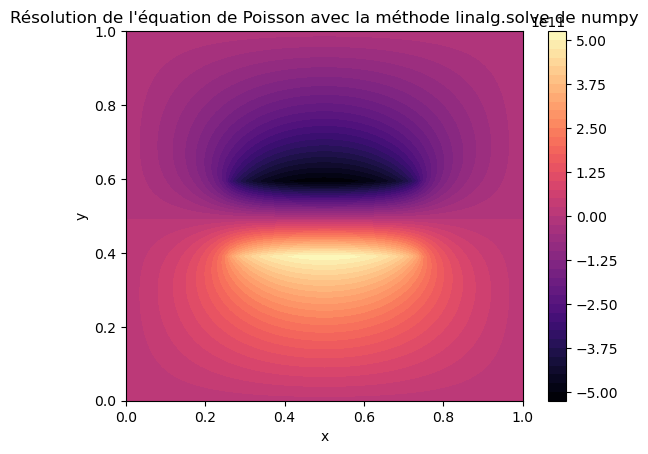

In [12]:
# Résolution de l'équation avec linalg.solve du module numpy 

start = time.time()
u1 = poisson_matrice_linalg(I,dx)
end = time.time()
temps_linalg = end-start
plt.figure(2)
plt.contourf(x,y,u1,41,cmap ='magma')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode linalg.solve de numpy")

C:\Users\Justin\AppData\Local\Temp\ipykernel_34004\4014760913.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  LnormInf = max(abs((x - x_old)))/max(abs(x_old))


Text(0.5, 1.0, "Résolution de l'équation de Poisson avec la méthode de sur relaxation")

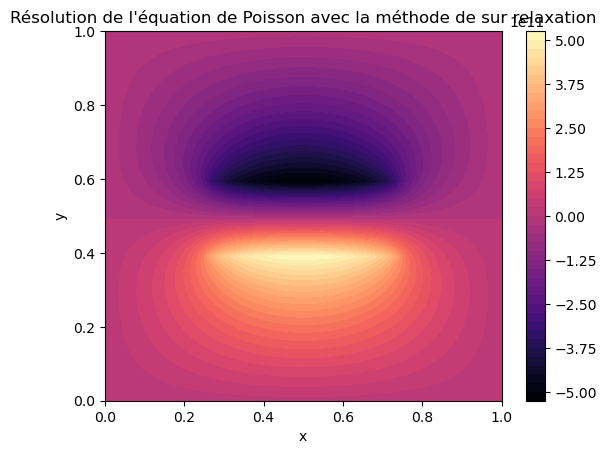

In [13]:
# Résolution de l'équation avec la méthode de sur-relaxation
A = A_sys(I,dx)
omega_opti = 2 / (1 + np.sin(np.pi * dx)) #w optimal pour l'équation de Poisson avec des conditions de Dirichlet, w=1 pour Gauss-Seidel
eps = 1e-7
max_iteration = 1000

start3 = time.time()
u3 = poisson_relax(A,-b,omega_opti,eps,max_iteration)
u4 = u3.reshape(65,65)
end3 = time.time()
temps_relaxation = end3-start3
plt.figure(2)
plt.contourf(x,y,u4,41,cmap ='magma')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Résolution de l'équation de Poisson avec la méthode de sur relaxation")



In [15]:
# Affichage du résultat
print('Le temps pour la méthode sparse est',temps_sparse)
print('Le temps pour la méthode linalg.solve est',temps_linalg)
print('Le temps pour la méthode sur relaxation est',temps_relaxation)
print('Le temps de calcul le plus court est',min(temps_sparse,temps_linalg,temps_relaxation))

Le temps pour la méthode sparse est 0.0319974422454834
Le temps pour la méthode linalg.solve est 0.39698076248168945
Le temps pour la méthode sur relaxation est 5.7721803188323975
Le temps de calcul le plus court est 0.0319974422454834


Le temps pour la méthode sparse est 0.0249178409576416
\
Le temps pour la méthode linalg.solve est 0.36421847343444824
\
Le temps pour la méthode sur relaxation est 5.2224342823028564

Le temps de calcul le plus court est 0.0249178409576416 de la méthode Sparse

On se rends compte ici que l'utilisation de matrices Sparse est ici un choix judicieux car on travaille avec des matrices quasi creuses qui sont adaptées au problème de l'équation de Poisson (source seulement réparti dans un petit coin de l'espace). Cette méthode est quasi 10 fois plus performante que l'utilisation classique de la résolution par linalg.solve et bien plus que la relaxation, même je ne pense pas avoir utilisé les paramètres les plus optimisés pour la relaxation. Je ne parle même pas de la méthode de Gauss qui est juste impossible à utiliser avec du N =65 (à part sur un supercalculateur...)

On obtient des résultats qui correspondent bien aux lignes de courant que l'on connaît bien d'un condensateur néanmoins il y a quelque chose que je n'arrive pas à expliquer, c'est la différence entre les valeurs obtenues analytiquement avec la méthode Sparse et celle avec np.linalg.solve et la relaxation. J'ai regardé comment la fonction linalg.solve était construite mais je n'ai pas compris d'où venait cette différence. Cependant, la méthode de relaxation donne les mêmes valeurs donc je me suis peut être trompé dans la méthode sparse en construisant la matrice sparse (erreur de coefficient éventuellement?).

Par ailleurs, les valeurs en ordre de grandeur du potentiel ne sont pas bonnes car on a pris e = 1 pour simplifier les calculs.

En Conclusion, nous proposons la méthode Sparse pour résoudre ce problème car elle semble plus simple et plus efficace, et plus juste au niveau du graphique car au centre on ne voit pas vraiment le caractère uniforme du champ pour les méthodes linalg et relaxation alors que c'est bien le cas pour la méthode sparse, même si cette méthode renvoie des valeurs différentes des deux autres méthodes. On supposera que cela vient éventuellement d'une erreur dans les coefficients des matrices mais nous n'avons pas su identifier l'erreur.

En Conclusion, nous proposons la méthode Sparse pour résoudre ce problème car elle semble plus simple et plus efficace, et plus juste au niveau du graphique car au centre on ne voit pas vraiment le caractère uniforme du champ pour les méthodes linalg et relaxation alors que c'est bien le cas pour la méthode sparse, même si cette méthode renvoie des valeurs différentes des deux autres méthodes. On supposera que cela vient éventuellement d'une erreur dans les coefficients des matrices mais nous n'avons pas su identifier l'erreur.